In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras import backend as K
K.set_image_data_format('channels_first')

import seaborn as sns
sns.set(font_scale=2, style="ticks")

/Users/egentry/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
HSC_ids = np.load("data/HSC_ids.npy")
HSC_ids

array([43158176442374224, 43158176442374373, 43158176442374445, ...,
       43159155694916013, 43159155694916476, 43159155694917496])

In [3]:
X = np.load("data/images.small.npy")
X.shape

(1866, 3, 50, 50)

# Get targets

In [4]:
df = pd.read_csv("data/2018_02_23-all_objects.csv")
df = df[df.selected]
df.head()



targets = df.drop_duplicates("HSC_id") \
            .set_index("HSC_id") \
    


targets = (targets.log_mass > 8) & (targets.log_mass < 9) & (targets.photo_z < .15)
print(targets.mean())
print(targets.sum())

0.2775
555


# Split training and validation sets

In [5]:
batch_size = 64

In [6]:
np.random.seed(seed=0)

randomized_indices = np.arange(X.shape[0])
np.random.shuffle(randomized_indices)

testing_fraction = 0.2
# make sure testing set size is an even multiple of 64
num_testing = (int(testing_fraction*X.shape[0]) // batch_size) * batch_size

testing_set_indices = randomized_indices[:int(num_testing)]
training_set_indices = np.array(list(set([*randomized_indices]) - set([*testing_set_indices])))

In [7]:
testing_set_indices.size


320

In [8]:
training_set_indices.size


1546

# Setup standard augmentation

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
print('Using real-time _simple_ data augmentation.')

h_before, w_before = X[0,0].shape
print("image shape before: ({},{})".format(h_before, w_before))

# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    horizontal_flip=True, # randomly apply a reflection (in x)
    vertical_flip=True, # randomly apply a reflection (in y)
    rotation_range=0, # randomly apply a rotation of angle randomly between 0 and `rotation_range`
    zoom_range=0.0,
    shear_range=0.0,
    channel_shift_range=0.0,
    rescale=0,
    width_shift_range=0.002,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.002,  # randomly shift images vertically (fraction of total height)
)

Using real-time _simple_ data augmentation.
image shape before: (50,50)


In [12]:
datagen.fit(X[training_set_indices])

# Setup `keras` model

In [13]:
n_conv_filters = 16
conv_kernel_size = 4
input_shape = X.shape[1:]

dropout_fraction = .25

nb_dense = 64

In [14]:
input_shape

(3, 50, 50)

In [15]:
model = Sequential()

model.add(Conv2D(n_conv_filters, conv_kernel_size,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))


model.add(Conv2D(n_conv_filters, conv_kernel_size*2,
                        padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Conv2D(n_conv_filters, conv_kernel_size*4,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Flatten())
model.add(Dense(2*nb_dense, activation="relu"))
model.add(Dense(nb_dense, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [16]:
learning_rate = 0.001
decay = 1e-5
momentum = 0.9

sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)

adam = Adam(lr=learning_rate)

In [17]:
model.compile(loss='binary_crossentropy', 
#               optimizer=sgd, 
              optimizer=adam,
#               metrics=["accuracy"]
             )

In [18]:
earlystopping = EarlyStopping(monitor='loss',
                              patience=35,
                              verbose=1,
                              mode='auto' )


# Run Basic Keras Model

In [19]:
goal_batch_size = 64
steps_per_epoch = max(2, training_set_indices.size//goal_batch_size)
batch_size = training_set_indices.size//steps_per_epoch
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epochs = 100
verbose=1

steps_per_epoch:  24
batch_size:  64


In [20]:
Y = targets[HSC_ids].values

In [21]:
# %%timeit -r 1 -n 1
history = model.fit_generator(datagen.flow(X[training_set_indices], Y[training_set_indices],
                                           batch_size=batch_size,
                                          ),
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=(X[testing_set_indices], Y[testing_set_indices]),
                              verbose=verbose,
                              callbacks=[earlystopping],
                              )  

Epoch 1/100
24/24 [==============================] - 11s 467ms/step - loss: 0.6138 - val_loss: 0.6136
Epoch 2/100
24/24 [==============================] - 11s 456ms/step - loss: 0.5916 - val_loss: 0.6189
Epoch 3/100
24/24 [==============================] - 10s 433ms/step - loss: 0.5841 - val_loss: 0.6113
Epoch 4/100
24/24 [==============================] - 10s 430ms/step - loss: 0.5755 - val_loss: 0.6078
Epoch 5/100
24/24 [==============================] - 10s 431ms/step - loss: 0.5890 - val_loss: 0.6059
Epoch 6/100
24/24 [==============================] - 10s 430ms/step - loss: 0.5814 - val_loss: 0.6074
Epoch 7/100
24/24 [==============================] - 11s 439ms/step - loss: 0.5698 - val_loss: 0.5978
Epoch 8/100
24/24 [==============================] - 10s 436ms/step - loss: 0.5757 - val_loss: 0.5953
Epoch 9/100
24/24 [==============================] - 11s 455ms/step - loss: 0.5671 - val_loss: 0.5909
Epoch 10/100
24/24 [==============================] - 11s 440ms/step - loss: 0.584

In [22]:
print("best performance: ", min(history.history["val_loss"]))

best performance:  0.567160916328


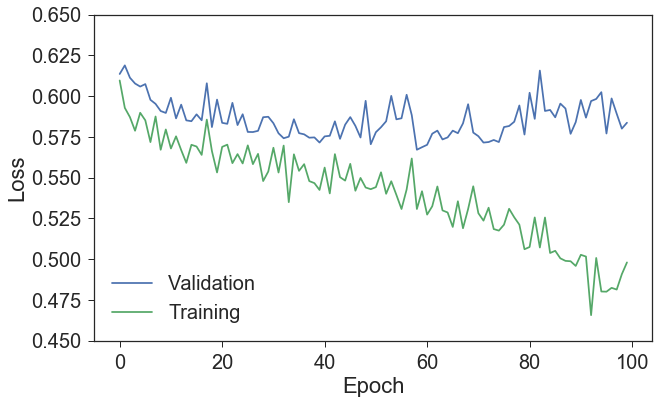

In [23]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):

    plt.plot(history.history["val_loss"], label="Validation")
    plt.plot(history.history["loss"], label="Training")


    plt.legend()
    
    plt.xlabel("Epoch")
#     plt.ylabel("Loss\n(avg. binary cross-entropy)")
    plt.ylabel("Loss")

    
    plt.ylim(.45, .65)

In [24]:
class_probs = model.predict_proba(X[testing_set_indices]).flatten()
class_probs

320/320 [==============================] - 1s 3ms/step


array([  2.07960024e-01,   4.10488874e-01,   7.14625493e-02,
         2.45205164e-01,   2.14313298e-01,   3.34103465e-01,
         1.10777274e-01,   1.07577413e-01,   3.75161767e-01,
         2.69392818e-01,   3.02978098e-01,   4.24791604e-01,
         3.92126322e-01,   4.12261993e-01,   4.05012041e-01,
         1.55116007e-01,   3.61026913e-01,   4.37614769e-01,
         1.33863971e-01,   3.70272189e-01,   2.37005666e-01,
         3.35596204e-01,   3.20842952e-01,   3.82638931e-01,
         7.14818835e-02,   7.56967664e-02,   9.28229243e-02,
         3.18641961e-01,   4.86468337e-03,   5.32901168e-01,
         4.35306907e-01,   2.32315600e-01,   1.04126386e-01,
         3.63019705e-01,   3.37179422e-01,   1.52644202e-01,
         4.71648902e-01,   4.11772430e-01,   4.23594415e-01,
         3.58814478e-01,   3.85543019e-01,   1.55201182e-01,
         2.76742399e-01,   4.47900146e-01,   4.47269827e-01,
         3.67768824e-01,   3.29839945e-01,   4.02819216e-01,
         2.86767185e-01,

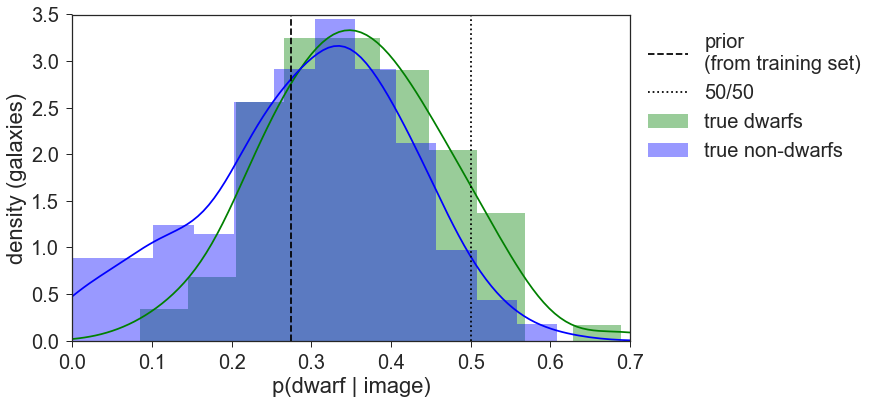

In [25]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    sns.distplot(class_probs[Y[testing_set_indices]==True], color="g", label="true dwarfs")
    sns.distplot(class_probs[Y[testing_set_indices]==False], color="b", label="true non-dwarfs")

    plt.xlabel("p(dwarf | image)")
    plt.ylabel("density (galaxies)")

    plt.xlim(0, .7)
    plt.axvline(Y[training_set_indices].mean(), linestyle="dashed", color="black", label="prior\n(from training set)")
    plt.axvline(.5, linestyle="dotted", color="black", label="50/50")

    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )


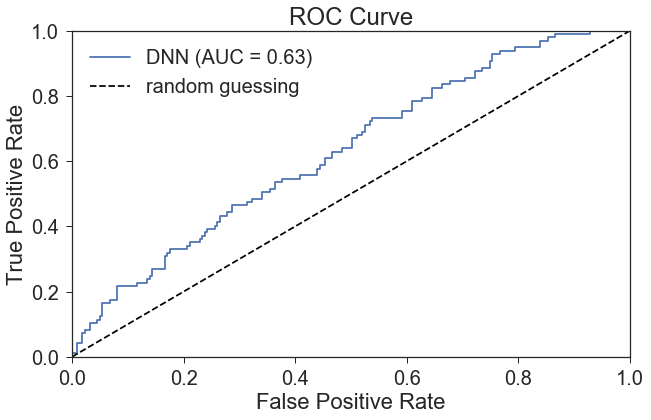

In [26]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    fpr, tpr, _ = metrics.roc_curve(Y[testing_set_indices], class_probs)
    roc_auc = roc_auc_score(Y[testing_set_indices], class_probs)

    plt.plot(fpr, tpr, label="DNN (AUC = {:.2})".format(roc_auc))
    plt.plot([0,1], [0,1], linestyle="dashed", color="black", label="random guessing")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("ROC Curve")

    plt.legend(loc="best")


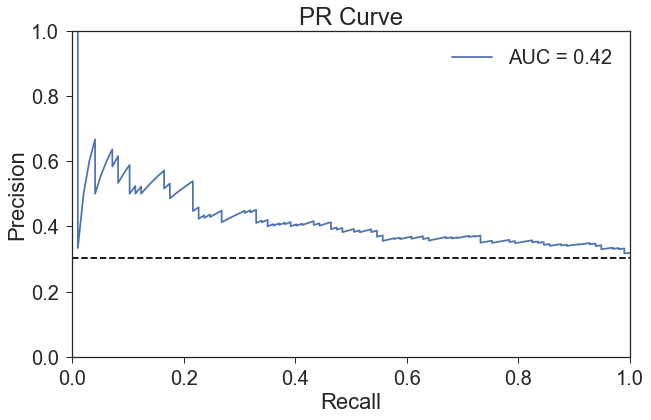

In [27]:
from sklearn import metrics
from sklearn.metrics import average_precision_score
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    precision, recall, _ = metrics.precision_recall_curve(Y[testing_set_indices], class_probs)
    pr_auc = average_precision_score(Y[testing_set_indices], class_probs)

    plt.plot(recall, precision, label="AUC = {:.2}".format(pr_auc))
    plt.plot([0,1], [Y[testing_set_indices].mean()]*2, linestyle="dashed", color="black")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.title("PR Curve")

    plt.legend(loc="best")
